# Calculating Plasma Characteristics

The measurement from the Lunar Prospector satellite is provided with significant detail:

15 energy levels, each of which contains 88 separately bins forming a spherical shell, reporting measurements in units of `particles / (cm^2 sec sr eV)`

The plasma, primarily sourced from the Solar Wind, is modeled by the kappa distribution: $f(v)= \frac{\Gamma(\kappa+1)}{(\pi \kappa)^{3/2} \Gamma(\kappa - 1/2)} \frac{n}{\Theta^3} \left[1 + \frac{v^2}{\kappa \Theta^2}\right]^{-\kappa - 1}$

From the measurements, we are able to directly infer the density, the subject of the rest of this file. $\kappa$ and $\Theta$ are solved by joint optimization, minimizing the distance between the forward model and measured flux.

In [ ]:
import glob

import matplotlib.pyplot as plt
import numpy as np

import src.config as config
from src.flux import ERData
from src.kappa import Kappa
from src.utils.units import ureg

Here we consider a data file chosen at random. We calculate the densities, and match them to the time when the measurement (the entirety of which takes 75 seconds) began.

As we would expect, we observe a periodic pattern with a period of about 7000 seconds or approximately 2 hours, which corresponds nicely with the 2 hour orbital period of the LP spacecraft. 

The highs correspond to direct exposure to solar wind plasma, while the lows correspond to the rarefied conditions of the wake region. There is a stark contrast of about 3 orders of magnitude.

In [2]:
root = config.PROJECT_ROOT
# sample_data_path = config.DATA_DIR / "1998/091_120APR/3D980403.TAB"
data_files = glob.glob(str(config.DATA_DIR / "199*" / "*" / "*"))

In [ ]:
MONTH_TO_NUM = {
    "JAN": "01",
    "FEB": "02",
    "MAR": "03",
    "APR": "04",
    "MAY": "05",
    "JUN": "06",
    "JUL": "07",
    "AUG": "08",
    "SEP": "09",
    "OCT": "10",
    "NOV": "11",
    "DEC": "12",
}

NUM_TO_MONTH = {int(value): key for key, value in MONTH_TO_NUM.items()}


def get_data_file(year: int, month: int, day: int):
    assert year in (1998, 1999), "LP years are 1998 and 1999"
    assert 1 <= month <= 12, "Months are between 1 and 12"
    assert 1 <= day <= 31, "Days are between 1 and 31"

    data_path = config.DATA_DIR / str(year)
    available_months = glob.glob(str(data_path / "*"))
    canonical_month = None
    for available_month in available_months:
        if NUM_TO_MONTH[month] in available_month:
            canonical_month = available_month
            break
    if canonical_month is None:
        raise Exception("Month not found.")

    data_path = data_path / canonical_month / f"3D{str(year)[2:]}{month:02}{day:02}.TAB"
    return str(data_path)

In [14]:
sample_data_path = get_data_file(1998, 4, 20)

er_data = ERData(sample_data_path)

In [ ]:
calculated_densities = []
calculated_kappas = []
calculated_thetas = []
calculated_errors = []
calculated_potential = []

for i in er_data.data["spec_no"].unique():
    kappa = Kappa(er_data, spec_no=i)
    density = kappa.density_estimate.to(ureg.particle / ureg.m**3).magnitude
    fit_result, spacecraft_potential = kappa.corrected_fit(
        n_starts=10
    )  # Reduced from 50 starts
    
    if fit_result is None:
        calculated_kappas.append(None)
        calculated_thetas.append(None)
        calculated_errors.append(None)
        calculated_potential.append(None)
        continue
    
    calculated_densities.append(density)
    calculated_kappas.append(fit_result.params.kappa)
    calculated_thetas.append(
        fit_result.params.theta.to(ureg.meter / ureg.second).magnitude
    )
    calculated_errors.append(fit_result.error)
    calculated_potential.append(spacecraft_potential)

In [ ]:
times = er_data.data["time"].unique()
times = times - np.min(times)  # Normalize time to start from 0
times = times / 3600  # Convert to hours

densities = np.array(calculated_densities)
kappas = np.array(calculated_kappas)
thetas = np.array(calculated_thetas)
errors = np.array(calculated_errors)

start_hour = 16
end_hour = 18

mask = (times >= start_hour) & (times < end_hour)
times = times[mask]
densities = densities[mask]
kappas = kappas[mask]
thetas = thetas[mask]
errors = errors[mask]

<Figure size 1000x600 with 0 Axes>

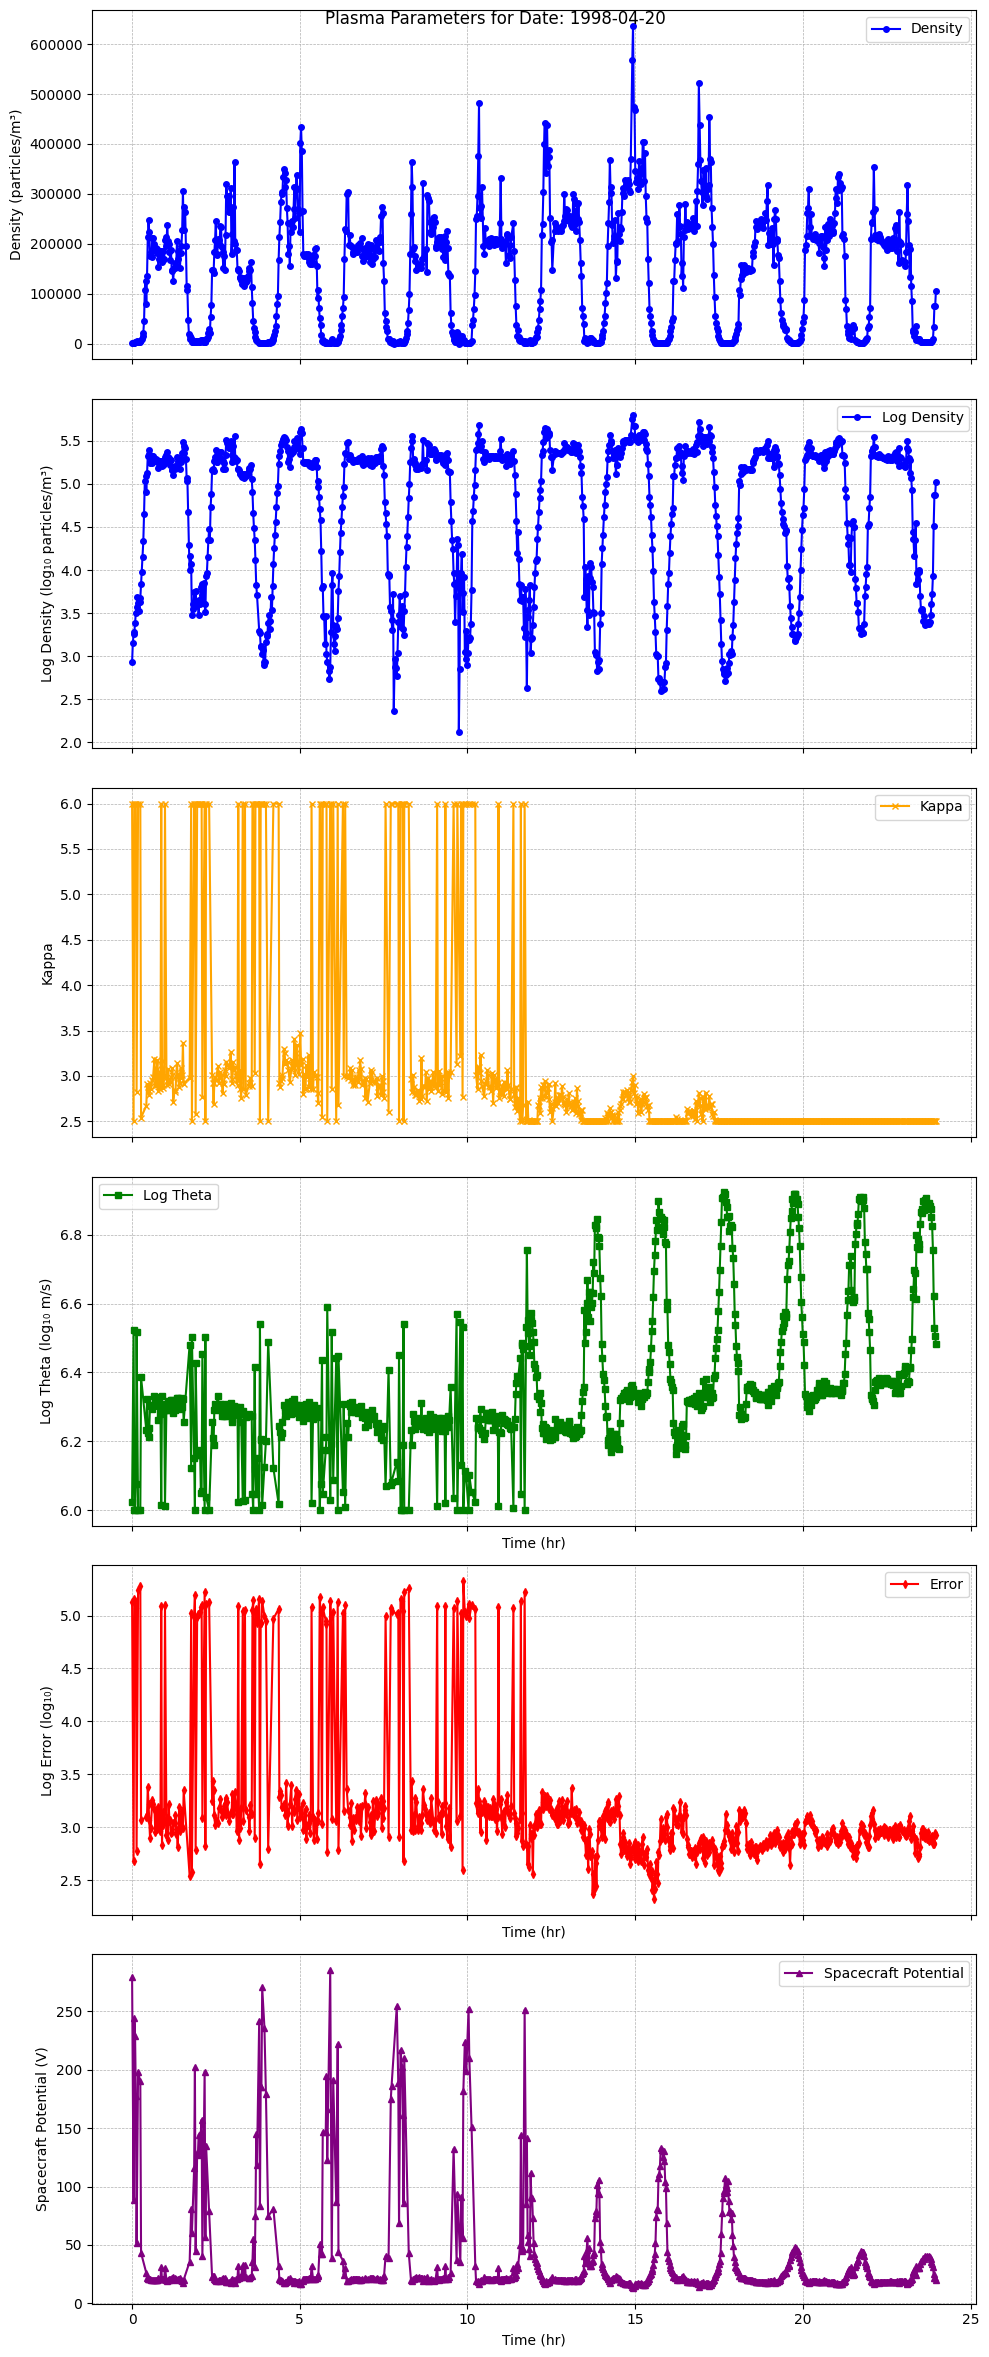

In [17]:
plt.figure(figsize=(10, 6))

# Filter out None values for plotting
valid_mask = np.array(
    [
        k is not None and t is not None and e is not None and p is not None
        for k, t, e, p in zip(
            kappas, thetas, errors, calculated_potential, strict=False
        )
    ]
)

times_valid = times[valid_mask]
densities_valid = densities[valid_mask]
kappas_valid = np.array([k for k in kappas if k is not None])
thetas_valid = np.array([t for t in thetas if t is not None])
errors_valid = np.array([e for e in errors if e is not None])
potential_valid = np.array([p for p in calculated_potential if p is not None])

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(10, 24), sharex=True)

# Density subplot (all densities should be valid)
ax1.plot(
    times,
    densities,
    label="Density",
    color="blue",
    marker="o",
    linestyle="-",
    markersize=4,
)
ax1.set_ylabel("Density (particles/m³)")
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)
ax1.legend()

# Log Density subplot (all densities should be valid)
ax2.plot(
    times,
    np.log10(densities),
    label="Log Density",
    color="blue",
    marker="o",
    linestyle="-",
    markersize=4,
)
ax2.set_ylabel("Log Density (log₁₀ particles/m³)")
ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
ax2.legend()

# Kappa subplot (filter out None values)
ax3.plot(
    times_valid,
    kappas_valid,
    label="Kappa",
    color="orange",
    marker="x",
    linestyle="-",
    markersize=4,
)
ax3.set_ylabel("Kappa")
ax3.grid(True, which="both", linestyle="--", linewidth=0.5)
ax3.legend()

# Log Theta subplot (filter out None values)
ax4.plot(
    times_valid,
    np.log10(thetas_valid),
    label="Log Theta",
    color="green",
    marker="s",
    linestyle="-",
    markersize=4,
)
ax4.set_ylabel("Log Theta (log₁₀ m/s)")
ax4.set_xlabel("Time (hr)")
ax4.grid(True, which="both", linestyle="--", linewidth=0.5)
ax4.legend()

# Error subplot (filter out None values)
ax5.plot(
    times_valid,
    np.log10(errors_valid),
    label="Error",
    color="red",
    marker="d",
    linestyle="-",
    markersize=4,
)
ax5.set_ylabel("Log Error (log₁₀)")
ax5.set_xlabel("Time (hr)")
ax5.grid(True, which="both", linestyle="--", linewidth=0.5)
ax5.legend()

# Spacecraft Potential subplot (filter out None values)
ax6.plot(
    times_valid,
    (potential_valid),
    label="Spacecraft Potential",
    color="purple",
    marker="^",
    linestyle="-",
    markersize=4,
)
ax6.set_ylabel("Spacecraft Potential (V)")
ax6.set_xlabel("Time (hr)")
ax6.grid(True, which="both", linestyle="--", linewidth=0.5)
ax6.legend()

fig.suptitle(f"Plasma Parameters for Date: {(er_data.data['UTC'].iloc[0])[:10]}")
plt.tight_layout()
plt.show()

# Testing the Density Fitter on Synthetic Data

Because we don't have an independent calculation of the density measured by the LP spacecraft, verification would be limited to dimensional analysis, type verification, and heuristic analysis of the predicted density.

However, the forward model that was designed to estimate the other parameters is sufficient to enable the approximation of satellite conditions given the parameters. In other words, we can create synthetic data to test the calculations, which is what we do below.

In [6]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import src.config as config
from src.flux import ERData
from src.kappa import Kappa
from src.physics.kappa import KappaParams, omnidirectional_flux
from src.utils.units import ureg

Here we prepare the synthetic data, i.e. the differential flux data that we would expect to see given the parameters of the kappa distribution. This is then conformed to the format of the LP spacecraft data.

In [7]:
def prepare_phis():
    phis = []
    phis_by_latitude = {
        78.75: ([], 4),
        56.25: ([], 8),
        33.75: ([], 16),
        11.25: ([], 16),
        -11.25: ([], 16),
        -33.75: ([], 16),
        -56.25: ([], 8),
        -78.75: ([], 4),
    }
    thetas = np.loadtxt(config.DATA_DIR / config.THETA_FILE, dtype=float)
    solid_angles = np.loadtxt(config.DATA_DIR / config.SOLID_ANGLES_FILE, dtype=float)
    for theta in thetas:
        current_phis = phis_by_latitude[theta]
        current_phis[0].append((len(current_phis[0])) / current_phis[1] * 360)
        phis.append(current_phis[0][-1])

    return phis, solid_angles


def prepare_flux(density=1e6, kappa=5.0, theta=1.1e5):
    params = KappaParams(
        density=density * ureg.particle / ureg.m**3,
        kappa=kappa,
        theta=theta * ureg.meter / ureg.second,
    )

    energy_centers = np.geomspace(2e1, 2e4, config.SWEEP_ROWS) * ureg.electron_volt
    np.column_stack([energy_centers * 0.75, energy_centers * 1.25])

    omnidirectional_particle_flux = omnidirectional_flux(
        parameters=params, energy=energy_centers
    )
    return omnidirectional_particle_flux, energy_centers


def prepare_synthetic_er(density=1e6, kappa=5.0, theta=1.1e5):
    phis, solid_angles = prepare_phis()
    omnidirectional_particle_flux, energy_centers = prepare_flux(
        density=density, kappa=kappa, theta=theta
    )

    synthetic_er_data = pd.DataFrame(columns=config.ALL_COLS)
    directional = omnidirectional_particle_flux / (4 * np.pi * ureg.steradian)  # J / sr
    directional = directional.to(
        ureg.particle
        / (ureg.centimeter**2 * ureg.second * ureg.steradian * ureg.electron_volt)
    )
    synthetic_er_data[config.FLUX_COLS] = np.repeat(
        directional.magnitude[:, None], config.CHANNELS, axis=1
    )
    # If needed, refer to previous flux calculation logic in documentation or version control.

    synthetic_er_data[config.PHI_COLS] = phis
    synthetic_er_data["UTC"] = "2025-07-25T12:30:00"
    synthetic_er_data["time"] = (
        pd.to_datetime(synthetic_er_data["UTC"]).astype(np.int64) // 10**9
    )
    synthetic_er_data["energy"] = energy_centers.to(ureg.electron_volt).magnitude
    synthetic_er_data["spec_no"] = 1

    np.random.seed(42)
    synthetic_er_data[config.MAG_COLS] = np.random.rand(3)

    return ERData.from_dataframe(synthetic_er_data, "NULL")

To test the recoverability of density, we consider a scenario with density $n = 10^{10} \text{ particles / m}^{3}$. We create synthetic data over a range of kappas and thetas, and graph the ratio of the recovered density to the actual density.

We see a narrow band centered at $10^7 \text{ m / s}$ as the zone of recoverability, a consequence of the energy range of the instrument. There is also a small dependence on $\kappa$.

Below, we also see that the range of parameters over which >90% recovery is possible is quite large.

Next steps are transforming the predicted / measured omnidirectional flux to a spacecraft current.

In [8]:
def predicted_actual_ratio(kappa: float, log_theta: float):
    param_tuple = (1e10, kappa, 10**log_theta)

    synthetic_er = prepare_synthetic_er(
        density=param_tuple[0], kappa=param_tuple[1], theta=param_tuple[2]
    )
    synthetic_kappa = Kappa(synthetic_er, spec_no=1)

    return (
        (
            synthetic_kappa.density_estimate
            / (param_tuple[0] * ureg.particle / ureg.m**3)
        )
        .to(ureg.dimensionless)
        .magnitude
    )

In [9]:
xs = np.linspace(2.0, 8.0, 100)
ys = np.linspace(3.0, 10.0, 100)
X, Y = np.meshgrid(xs, ys)
Z = np.vectorize(predicted_actual_ratio)(X, Y)

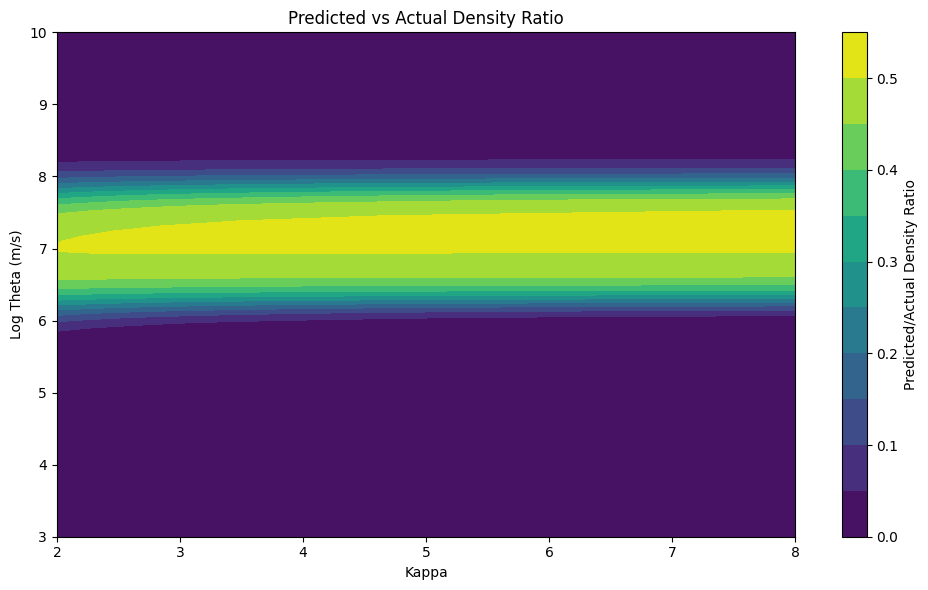

In [10]:
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, Z, levels=10, cmap="viridis")
plt.colorbar(label="Predicted/Actual Density Ratio")
plt.title("Predicted vs Actual Density Ratio")
plt.xlabel("Kappa")
plt.ylabel("Log Theta (m/s)")
plt.tight_layout()
plt.show()

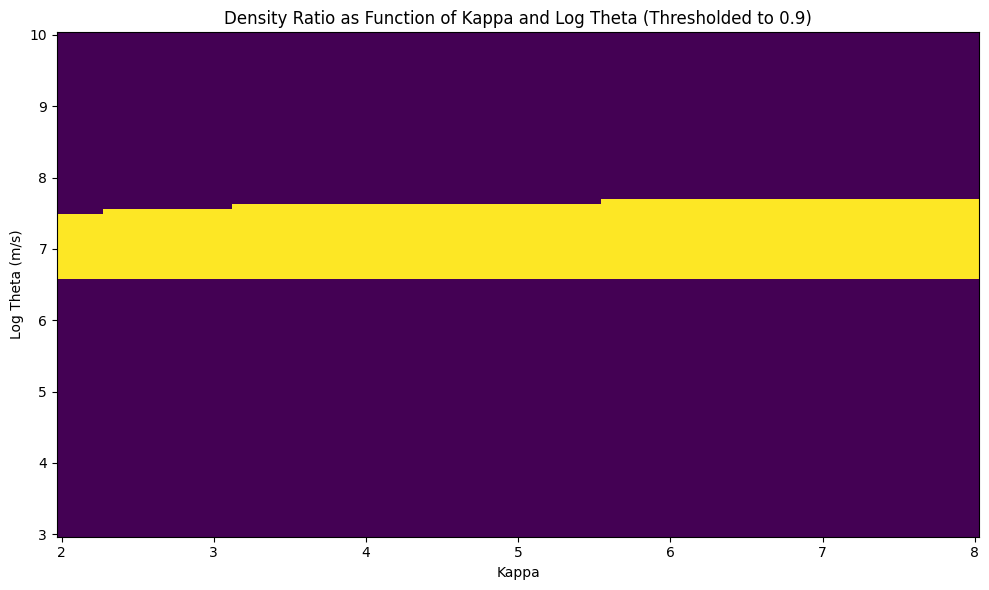

In [11]:
plt.figure(figsize=(10, 6))
threshold = 0.9
Z_healthy = np.where(Z < threshold * 0.5, 0, 1)
# plt.contourf(X, Y, Z_healthy, levels=2, cmap='viridis')
plt.pcolormesh(X, Y, Z_healthy, cmap="viridis", shading="auto")
plt.title(
    f"Density Ratio as Function of Kappa and Log Theta (Thresholded to {threshold})"
)
plt.xlabel("Kappa")
plt.ylabel("Log Theta (m/s)")
plt.tight_layout()
plt.show()